# Single-Cell RNA-seq Analysis: NMF-based Spermatogenesis Trajectory Analysis

This notebook performs Non-negative Matrix Factorization (NMF) analysis on single-cell RNA-seq data to identify spermatogenesis trajectories and cell type progression patterns in testicular tissue.

## Key Analysis Steps:
- **Data Processing**: Load and preprocess scRNA-seq data (filtered/raw/emptydrops)
- **Gene Selection**: Identify highly variable genes for dimensionality reduction
- **NMF Decomposition**: Apply NMF to extract biological components and patterns
- **Trajectory Analysis**: Map spermatogenesis progression from stem cells to mature sperm
- **Visualization**: Generate UMAPs and progression plots to visualize cell trajectories

## Expected Outputs:
- Cell type identification and clustering
- Spermatogenesis progression scores
- Component analysis revealing biological processes
- Trajectory visualization and validation

-- Nachfolger "foreground2.ipynb"

NMF: X = W x H (abzüglich ungenauigkeit reduktion)

# IMPORTS

In [3]:
import scanpy as sc
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import time
import pickle
from datetime import datetime
import multiprocessing as mp

# DEF var & LOAD "matrix" + "matrix_array"

In [4]:
# choose from "filtered" , "raw" , "emptydrops"
source_data = "emptydrops"

normalization_target = 1e4

# decide how many highly variable genes to use in NMF on data
n_variable_genes = 2000

# decide on how many components to use in NMF on data
test_components = 10
components = 20


#-------------------------------------------------------------------
#load data
#-------------------------------------------------------------------
def load_matrix(name): # load as anndata
    if name == "filtered":
        matrix = sc.read_10x_h5("data/filtered_feature_bc_matrix.h5")
        return matrix
    elif name == "raw":
        matrix = sc.read_10x_h5("data/raw_feature_bc_matrix.h5")
        return matrix
    elif name == "emptydrops":
        matrix = sc.read_h5ad("data/emptydrops_all_detected_cells.h5ad")
        return matrix
    else:
        raise ValueError(f"Invalid matrix name: {name}")

matrix = load_matrix(source_data)
matrix # is an anndata object

matrix_array = matrix.X.toarray()
matrix_array # is a numpy array

array([[ 1.,  0.,  1., ...,  0., 17.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.]], dtype=float32)

# NORMALIZE data

In [5]:
def normalize_data(matrix, normalization_target):
    row_sums = matrix.X.sum(axis=1)
    if hasattr(row_sums, 'A1'):  # Handle sparse matrix case
        row_sums = row_sums.A1

    unique_sums = np.unique(row_sums)

    if len(unique_sums) == 1:
        print("All cells have identical total UMI counts - no normalization needed")
    else:
        print(f"Range (rpow sums): {row_sums.min():.2f} to {row_sums.max():.2f}")
        print(f"Standard abweichungg: {row_sums.std():.2f}")
        print(f"coefficient of variation: {row_sums.std()/row_sums.mean()*100:.2f}%")
        print("*****NROMALIZATION MAY BE REQUIRED*****")

        # ask user if they want to normalize
        #normalize = input("Do you want to normalize the data? (y/n)")
        normalize = "y" # input not possible in jupyter notebook

        if normalize == "y":
            print("matrix before norm: ", matrix.X.sum(axis=1))

            # normalize matrix ovr all cells
            sc.pp.normalize_total(matrix, target_sum=normalization_target)
            
            print("matrix after normalization: ", matrix.X.sum(axis=1))
            
            # Verify normalization
            normalized_row_sums = matrix.X.sum(axis=1)
            if hasattr(normalized_row_sums, 'A1'):
                normalized_row_sums = normalized_row_sums.A1
            print(f"After normalization yippih (rounded to 10th decimal): {normalized_row_sums.min():.10f} to {normalized_row_sums.max():.10f}")
        else:
            print("NO NORMALIZATION PERFORMED")
    
    return matrix

# Run the function
matrix_normalized = normalize_data(matrix, normalization_target)


Range (rpow sums): 151.00 to 255392.00
Standard abweichungg: 5222.42
coefficient of variation: 209.75%
*****NROMALIZATION MAY BE REQUIRED*****
matrix before norm:  [[11029.]
 [  256.]
 [ 1100.]
 ...
 [  163.]
 [  272.]
 [  313.]]
matrix after normalization:  [[ 9999.999]
 [10000.   ]
 [10000.   ]
 ...
 [10000.   ]
 [ 9999.999]
 [10000.   ]]
After normalization yippih (rounded to 10th decimal): 9999.9970703125 to 10000.0048828125


# first pipeline

## PLOT                 - umi counts

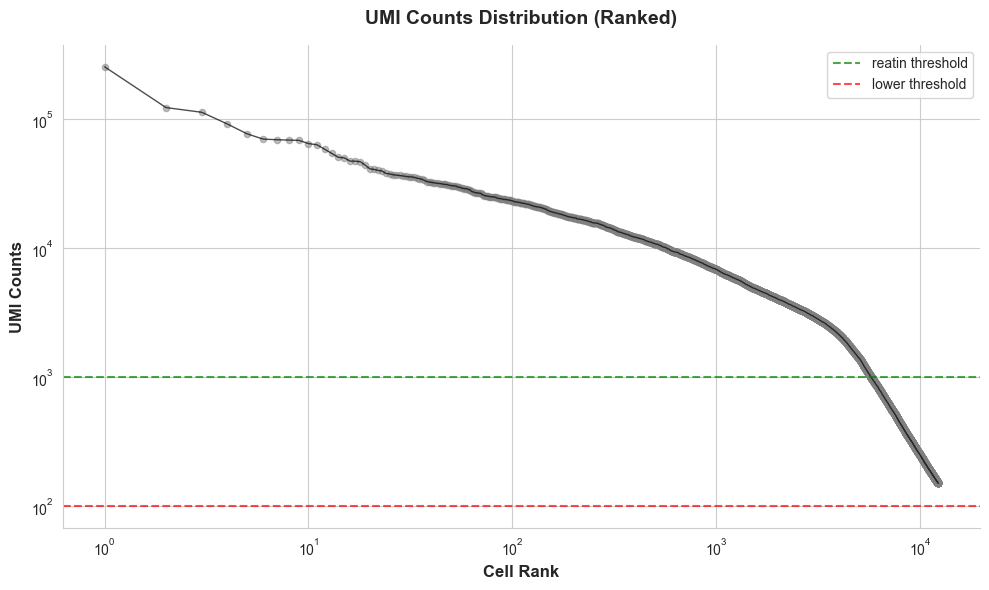

In [6]:
# Calculate UMI counts per cell (sum across genes for each cell)
umi_counts = matrix_array.sum(axis=1)

# Sort UMI counts in descending order
sorted_counts = np.sort(umi_counts)[::-1]
cell_ranks = np.arange(1, len(sorted_counts) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create scatter plot with connected lines
plt.plot(cell_ranks, sorted_counts, color='black', linewidth=1, alpha=0.7)
plt.scatter(cell_ranks, sorted_counts, color='grey', s=20, alpha=0.5)

# Add threshold lines
plt.axhline(y=1000, color='green', linestyle='--', alpha=0.7, label='reatin threshold')
plt.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='lower threshold')

# Customize the plot
plt.xlabel('Cell Rank', fontsize=12, fontweight='bold')
plt.ylabel('UMI Counts', fontsize=12, fontweight='bold')
plt.title('UMI Counts Distribution (Ranked)', 
          fontsize=14, fontweight='bold', pad=15)

# log scale
plt.yscale('log')
plt.xscale('log')

# Add legend
plt.legend()

# Add some styling
plt.tick_params(labelsize=10)
sns.despine()

# Adjust layout and display
plt.tight_layout()
plt.show()


## PREPROCESS   - sort rank matrix (UMI)

In [7]:
def preprocess_rank_cells(matrix):

    # UMI counts pro jede Zelle berechnen
    umi_counts = np.array(matrix.X.sum(axis=1)).flatten()

    # zellen nach umi count sortieren
    sorted_indices = np.argsort(umi_counts)[::-1]  # [::-1] = absteigend
    sorted_umi_counts = umi_counts[sorted_indices]

    # Zell-Ränge erstellen (1, 2, 3, ...)
    cell_ranks = np.arange(1, len(sorted_indices) + 1)

    print(f"Zelle mit höchstem UMI (Rang 1): {sorted_umi_counts[0]:.0f} UMIs")
    print(f"Zelle mit niedrigstem UMI (Rang {len(cell_ranks)}): {sorted_umi_counts[-1]:.0f} UMIs")

    # wende sorierung auf matrix_copy an
    matrix_sorted = matrix[sorted_indices, :]

    print(f"\nOriginal matrix shpe: {matrix.shape}")
    print(f"Sorted matrix shape: {matrix_sorted.shape}")

    # Verify the sorting worked on the AnnData object
    verification_umi = np.array(matrix_sorted.X.sum(axis=1)).flatten()
    print(f"\nVerification - first 5 UMI counts in sorted matrix: {verification_umi[:5]}")
    print(f"Should match sorted_umi_counts: {sorted_umi_counts[:5]}")
    print(f"Arrays are equal: {np.array_equal(verification_umi, sorted_umi_counts)}")

    # Transpose matrix_sorted um die dimensionen zu ändern/tauschen
    # -> NMF benötigt die dimensionen (genes, cells), davor hatten wir (zellen, genes)

    # produces error and NMF takes like 15x longer to run
    #matrix_sorted = matrix_sorted.copy().transpose()
    print(f"\nTransposed matrix shape: {matrix_sorted.shape}")
    
    return matrix_sorted

matrix_sorted = preprocess_rank_cells(matrix_normalized)

Zelle mit höchstem UMI (Rang 1): 10000 UMIs
Zelle mit niedrigstem UMI (Rang 12315): 10000 UMIs

Original matrix shpe: (12315, 22040)
Sorted matrix shape: (12315, 22040)

Verification - first 5 UMI counts in sorted matrix: [10000.005 10000.004 10000.004 10000.003 10000.003]
Should match sorted_umi_counts: [10000.005 10000.004 10000.004 10000.003 10000.003]
Arrays are equal: True

Transposed matrix shape: (12315, 22040)


## NMF                  - calculate

In [8]:
# fit model with the two different components approaches
model_test_comp = NMF(n_components=test_components, max_iter=10000)
model = NMF(n_components=components, max_iter=1000)

In [9]:
# model_test_comp
W_test_comp = model_test_comp.fit_transform(matrix_sorted.X)
H_test_comp = model_test_comp.components_
print(f"model_test_comp W shape: {W_test_comp.shape}")
print(f"model_test_comp H shape: {H_test_comp.shape}")

# model
W = model.fit_transform(matrix_sorted.X)  # This gives us sorted W matrix
H = model.components_  # H matrix remains the same

print(f"model W shape: {W.shape}")
print(f"model H shape: {H.shape}")

KeyboardInterrupt: 

## ERROR() calculation

In [ ]:
# function for error which gets parameter the matrix and the W and H matrix
def error(matrix, W, H):
    reconstructed_matrix = W @ H
    residual = matrix.X - reconstructed_matrix
    residual_norm_squared = np.linalg.norm(residual)**2
    original_norm_squared = np.linalg.norm(matrix.X.toarray())**2
    err = residual_norm_squared / original_norm_squared
    return err

err_matrix = error(matrix, W, H)
err_matrix_test_comp = error(matrix, W_test_comp, H_test_comp)
print("components: ", components, "-> err matrix: ", err_matrix)
print("components: ", test_components, "-> err matrix_test_comp: ", err_matrix_test_comp)

components:  20 -> err matrix:  1.1613996391321622
components:  10 -> err matrix_test_comp:  1.1401495462030418


## HEATMAP         - reconstruction on test_ & components


Reconstruction error (n=1): 0.1133
Reconstruction error (n=5): 0.1084


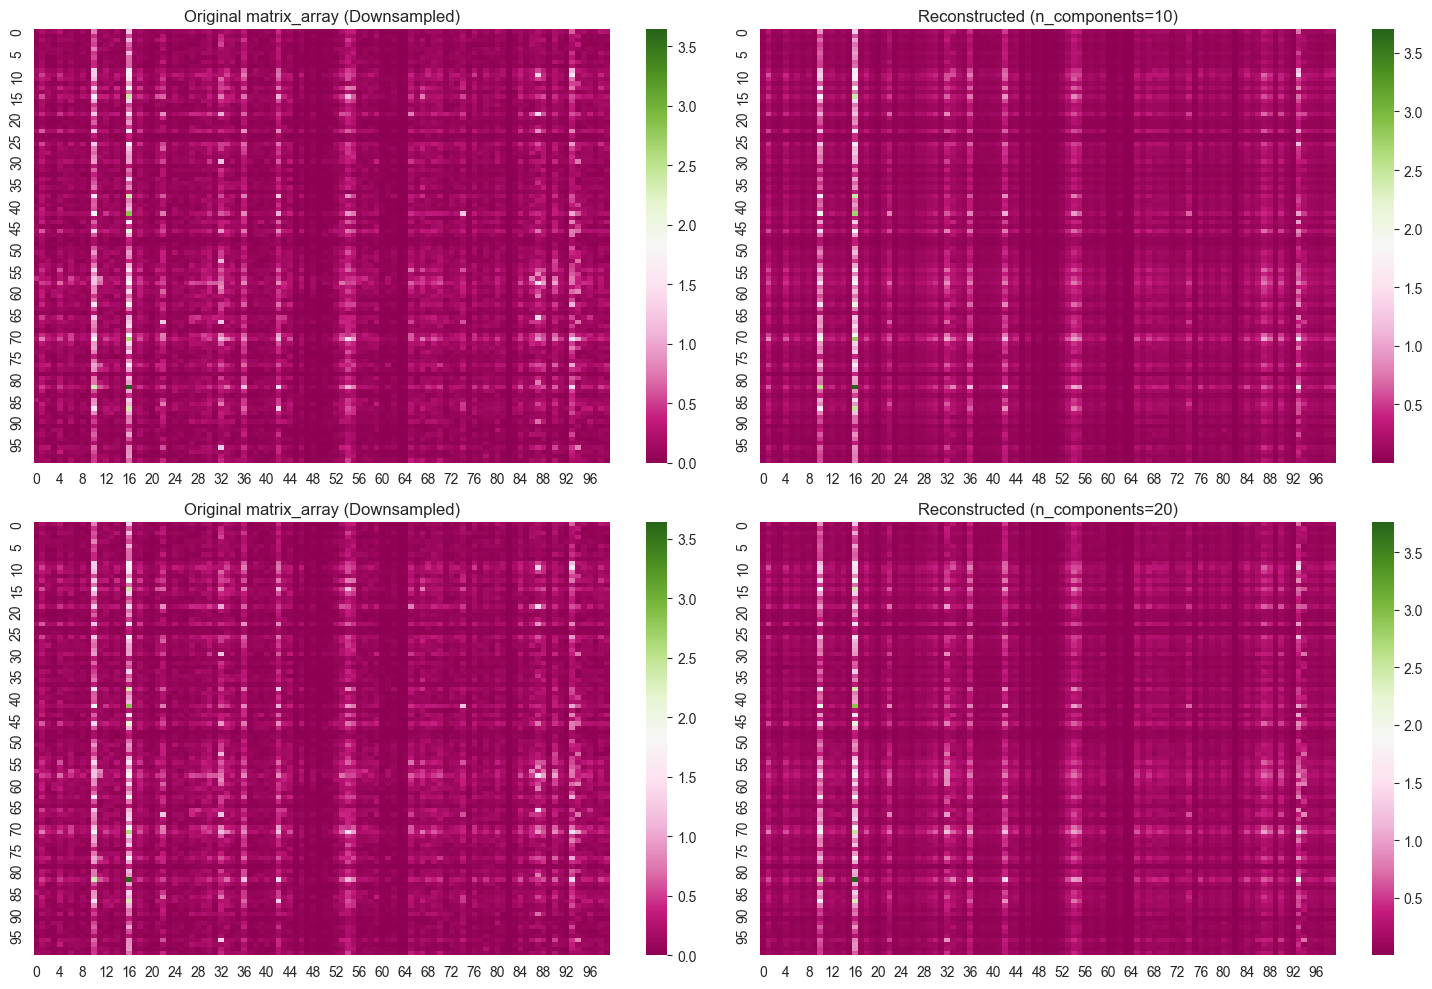

In [ ]:
# Create models with different numbers of components
#model_test_comp = NMF(n_components=test_components, max_iter=10000).fit(matrix_array)
#model = NMF(n_components=components, max_iter=10000).fit(matrix_array)

# Get reconstructions
reconstructed_test_comp = model_test_comp.inverse_transform(model_test_comp.transform(matrix_array))
reconstructed = model.inverse_transform(model.transform(matrix_array))

# Calculate reconstruction errors
error_test_comp = np.mean(np.abs(matrix_array - reconstructed_test_comp))
error = np.mean(np.abs(matrix_array - reconstructed))
print(f'\nReconstruction error (n=1): {error_test_comp:.4f}')
print(f'Reconstruction error (n=5): {error:.4f}')

# Create figure with subplots
plt.figure(figsize=(15, 10))

# Downsample parameters
block_size = 10
rows = matrix_array.shape[0] // block_size
cols = matrix_array.shape[1] // block_size
downsampled = matrix_array[:rows*block_size, :cols*block_size].reshape(rows, block_size, cols, block_size).mean(axis=(1,3))

# Plot for n_components = 1
plt.subplot(221)
sns.heatmap(downsampled[:100,:100], cmap='PiYG')
plt.title('Original matrix_array (Downsampled)')

plt.subplot(222)
downsampled_recon_test_comp = reconstructed_test_comp[:rows*block_size, :cols*block_size].reshape(rows, block_size, cols, block_size).mean(axis=(1,3))
sns.heatmap(downsampled_recon_test_comp[:100,:100], cmap='PiYG')
plt.title(f'Reconstructed (n_components={test_components})')

# Plot for n_components = 2
plt.subplot(223)
sns.heatmap(downsampled[:100,:100], cmap='PiYG')
plt.title('Original matrix_array (Downsampled)')

plt.subplot(224)
downsampled_recon = reconstructed[:rows*block_size, :cols*block_size].reshape(rows, block_size, cols, block_size).mean(axis=(1,3))
sns.heatmap(downsampled_recon[:100,:100], cmap='PiYG')
plt.title(f'Reconstructed (n_components={components})')

plt.tight_layout()
plt.show()


## PLOTS               - components against genes

### 1. expression pattern plot

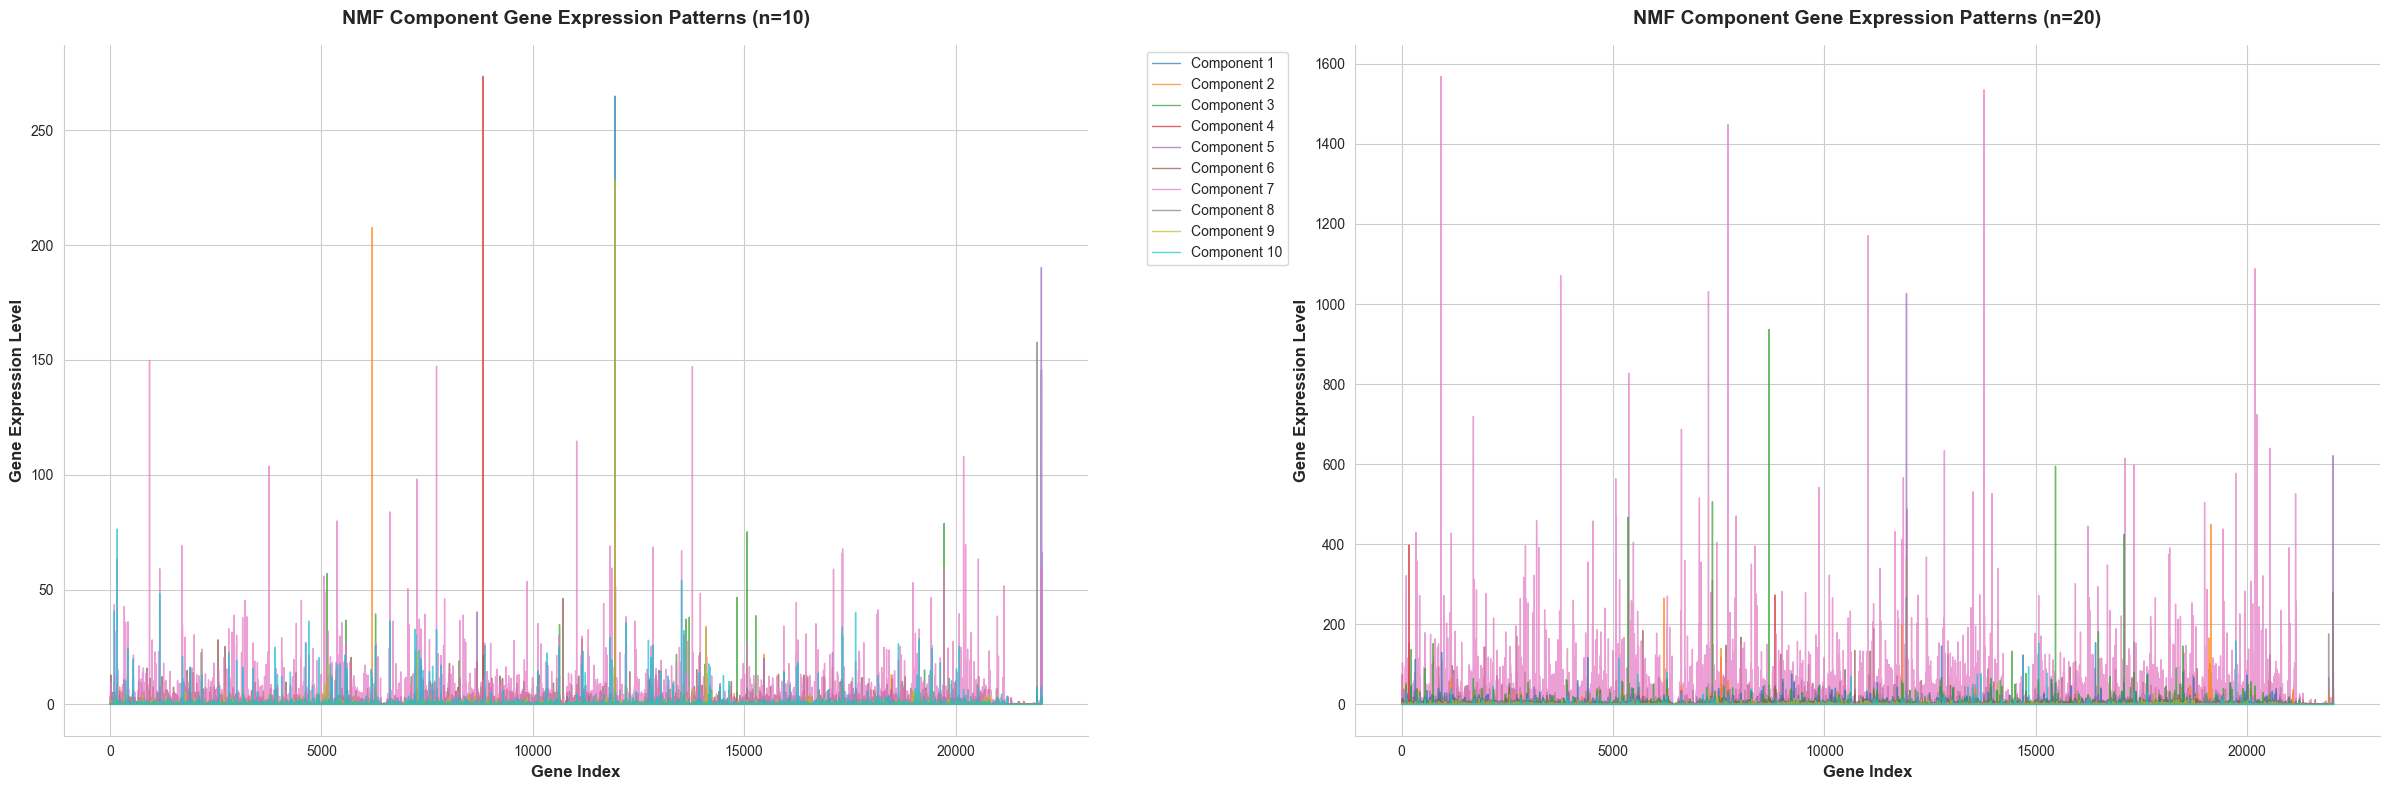

In [ ]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
sns.set_style("whitegrid")

# Plot for test_components
for i in range(H_test_comp.shape[0]):
    ax1.plot(H_test_comp[i], label=f'Component {i+1}', linewidth=1, alpha=0.7)

ax1.set_xlabel('Gene Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Gene Expression Level', fontsize=12, fontweight='bold')
ax1.set_title(f'NMF Component Gene Expression Patterns (n={test_components})', fontsize=14, fontweight='bold', pad=15)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(labelsize=10)
sns.despine(ax=ax1)

# Plot for components
for i in range(H.shape[0]):
    ax2.plot(H[i], label=f'Component {i+1}', linewidth=1, alpha=0.7)

ax2.set_xlabel('Gene Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Gene Expression Level', fontsize=12, fontweight='bold')
ax2.set_title(f'NMF Component Gene Expression Patterns (n={components})', fontsize=14, fontweight='bold', pad=15)
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()


#### notes
first error was to plot gene expression level on y-axis against the genes on x-axis which leaded to random high line plots with a lot of trouble and no real trend line possible to see
-> i used H before, while W = (Zells x components), H = (component x genomes) to plot expression level per genome which was useless. so i switched to using W to plot gene index per cell. need to make sure to plot against decreasing UMI count sorted cells, but since i sorted before doing NMF the information should still be avaible in W matrix.

### 2. y_log expression pattern plot

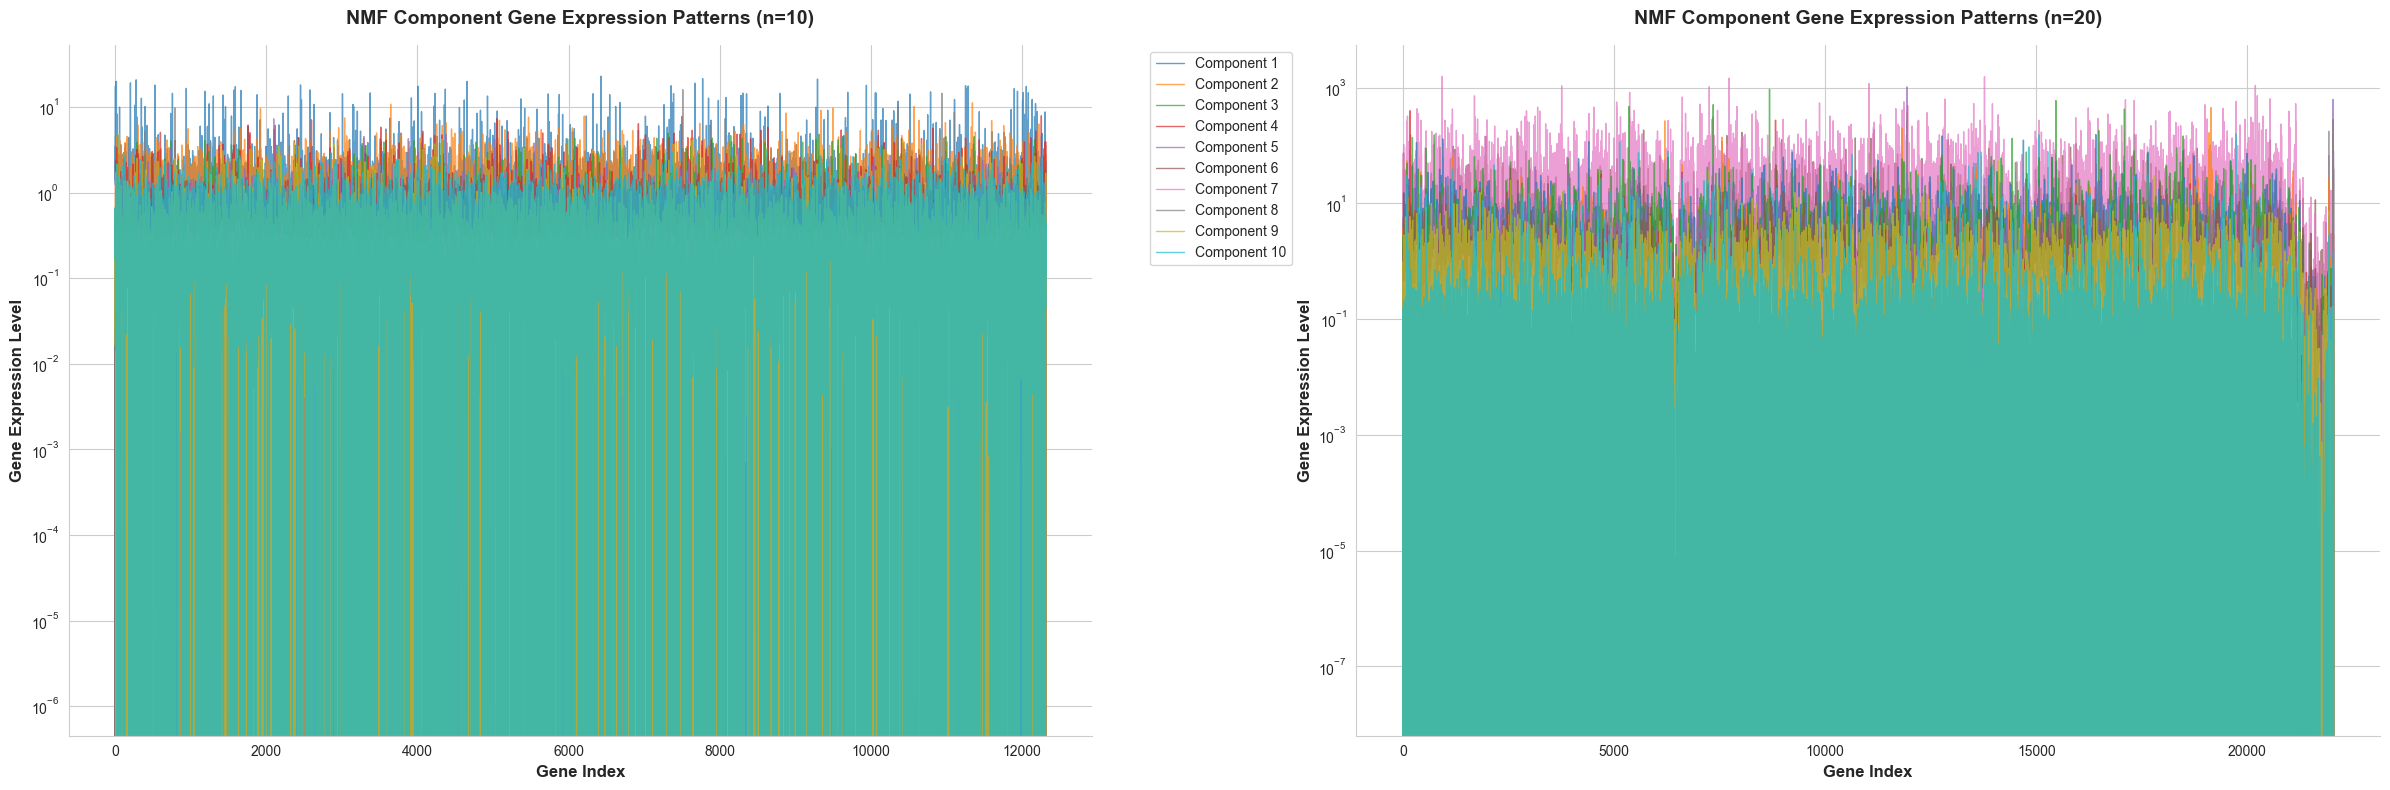

In [ ]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
sns.set_style("whitegrid")

# Plot for test_components
for i in range(W_test_comp.shape[1]): #iterate over components (W = (Zells x components))
    ax1.plot(W_test_comp[:,i], label=f'Component {i+1}', linewidth=1, alpha=0.7)

ax1.set_xlabel('Gene Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Gene Expression Level', fontsize=12, fontweight='bold')
ax1.set_title(f'NMF Component Gene Expression Patterns (n={test_components})', fontsize=14, fontweight='bold', pad=15)
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(labelsize=10)
sns.despine(ax=ax1)

# Plot for components
for i in range(H.shape[0]):
    ax2.plot(H[i], label=f'Component {i+1}', linewidth=1, alpha=0.7)

ax2.set_xlabel('Gene Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Gene Expression Level', fontsize=12, fontweight='bold')
ax2.set_title(f'NMF Component Gene Expression Patterns (n={components})', fontsize=14, fontweight='bold', pad=15)
ax2.set_yscale('log')
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()


### 3. corrected plot against cell not genome

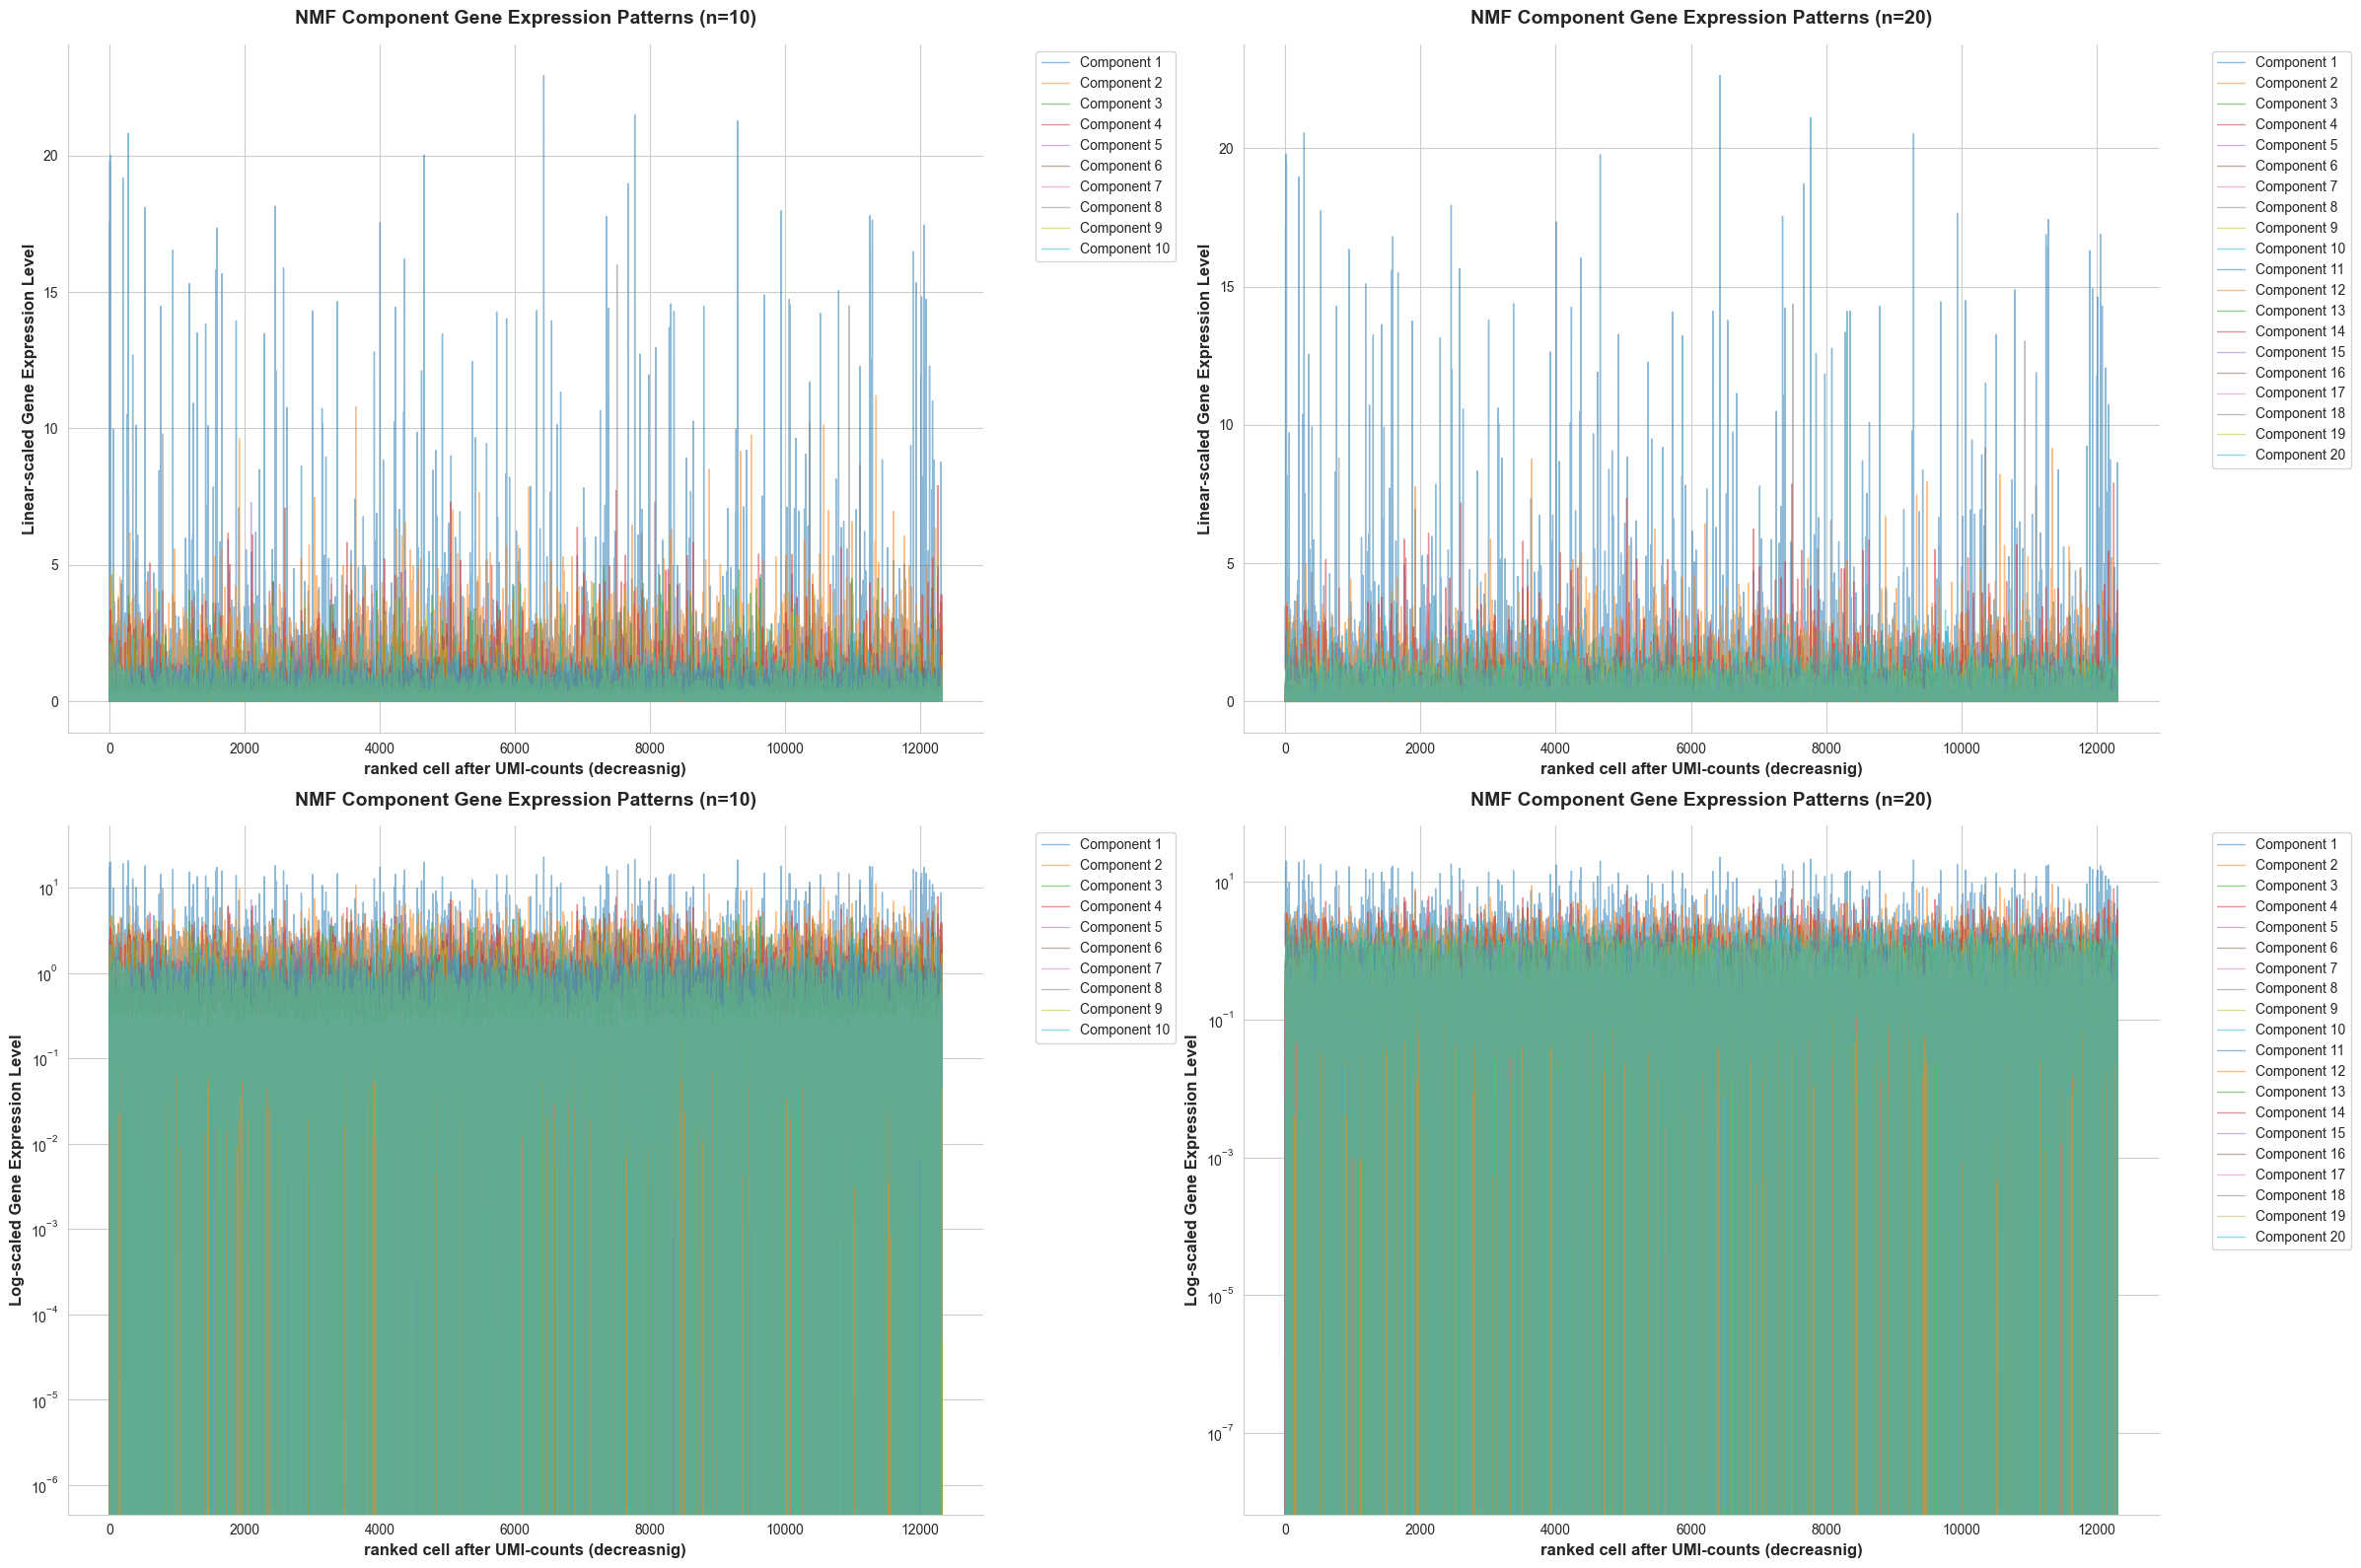

In [ ]:
# Create figure with 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 16))
sns.set_style("whitegrid")

# Helper function to create plots
def create_plot(ax, data, n_components, use_log=True):
    for i in range(data.shape[1]):
        ax.plot(data[:,i], label=f'Component {i+1}', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('ranked cell after UMI-counts (decreasnig)', fontsize=12, fontweight='bold')
    scale_type = 'Log-scaled' if use_log else 'Linear-scaled'
    ax.set_ylabel(f'{scale_type} Gene Expression Level', fontsize=12, fontweight='bold')
    ax.set_title(f'NMF Component Gene Expression Patterns (n={n_components})', 
                fontsize=14, fontweight='bold', pad=15)
    if use_log:
        ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(labelsize=10)
    sns.despine(ax=ax)

# Create all four plots
create_plot(ax1, W_test_comp, test_components, use_log=False)
create_plot(ax2, W, components, use_log=False)
create_plot(ax3, W_test_comp, test_components, use_log=True)
create_plot(ax4, W, components, use_log=True) 

plt.tight_layout()
plt.show()

### 4. smoothen plots out of "3."

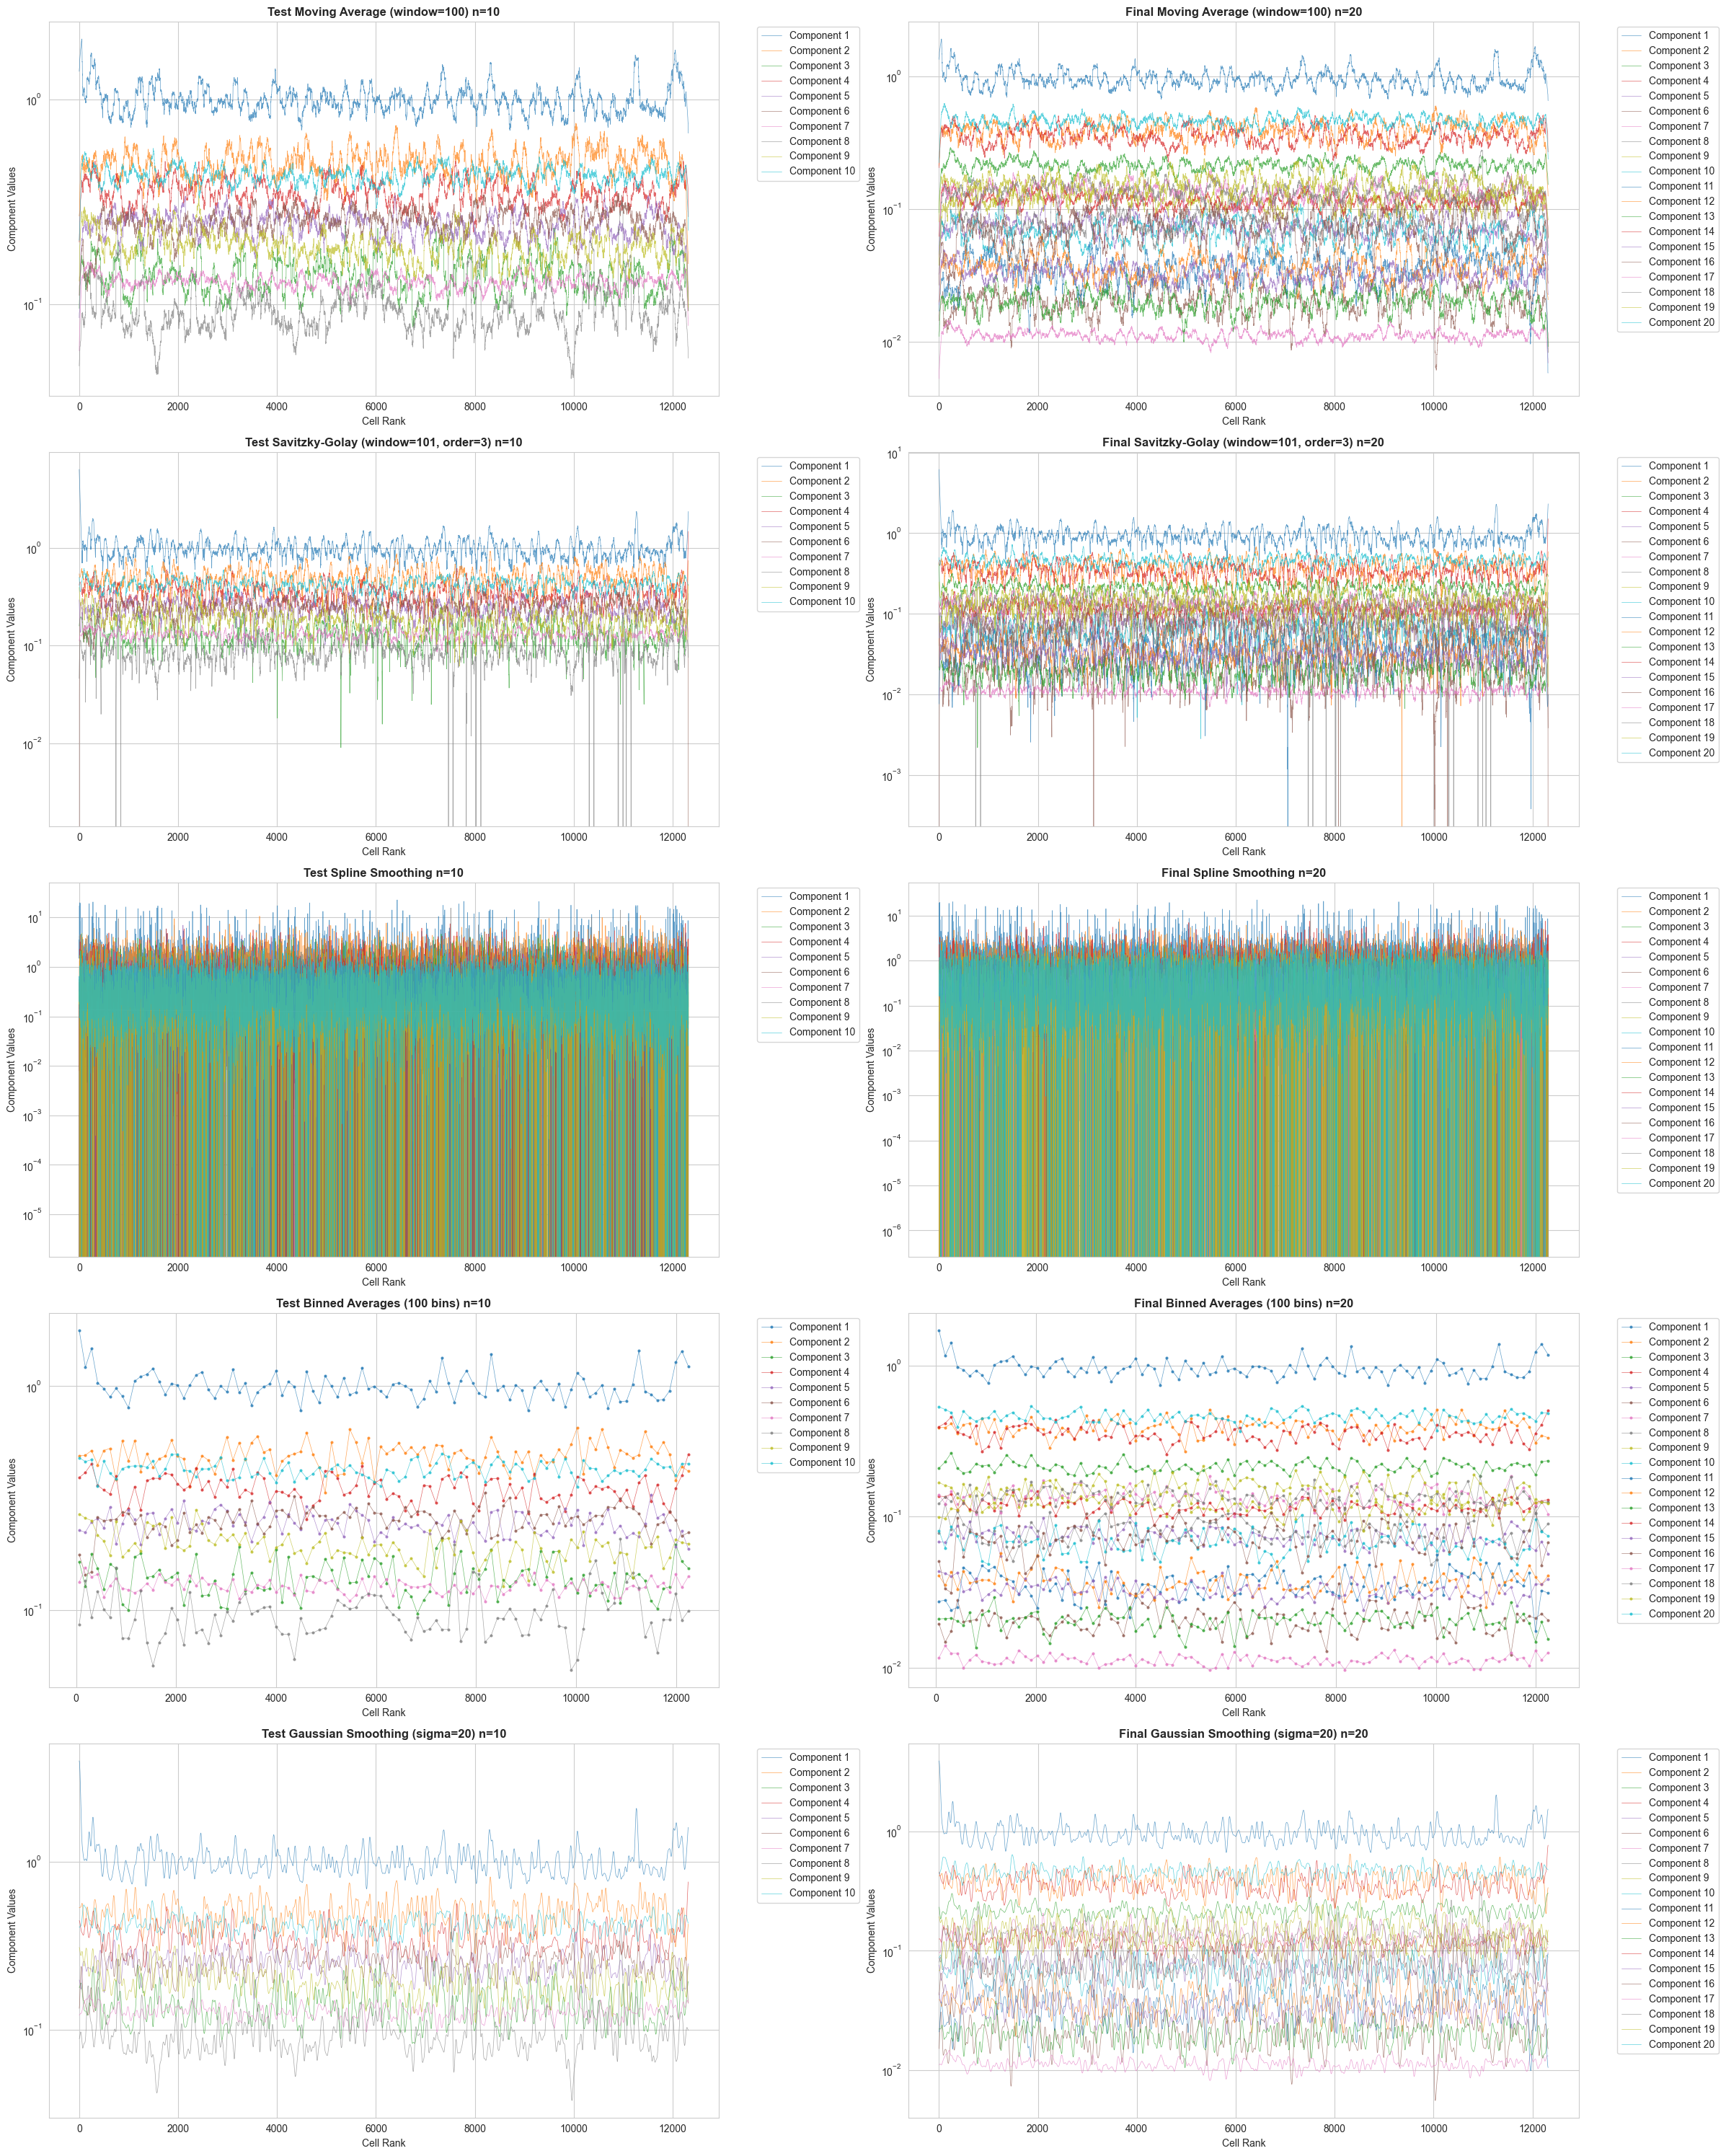

In [ ]:
# Smoothing plot with multiple methods
fig, axes = plt.subplots(5, 2, figsize=(24, 30))

# -----------
# Moving average
# -----------
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Plot test components with moving average smoothing
for i in range(W_test_comp.shape[1]):
    component_values = W_test_comp[:, i]
    smoothed = moving_average(component_values, 100)
    axes[0,0].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[0,0].set_title(f'Test Moving Average (window=100) n={test_components}', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Cell Rank')
axes[0,0].set_ylabel('Component Values')
axes[0,0].set_yscale('log')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot final components with moving average smoothing
for i in range(W.shape[1]):
    component_values = W[:, i]
    smoothed = moving_average(component_values, 100)
    axes[0,1].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[0,1].set_title(f'Final Moving Average (window=100) n={components}', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Cell Rank')
axes[0,1].set_ylabel('Component Values')
axes[0,1].set_yscale('log')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# -----------
# Savitzky-Golay
# -----------
from scipy.signal import savgol_filter

# Plot test components with Savitzky-Golay smoothing
for i in range(W_test_comp.shape[1]):
    component_values = W_test_comp[:, i]
    smoothed = savgol_filter(component_values, window_length=101, polyorder=3)
    axes[1,0].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[1,0].set_title(f'Test Savitzky-Golay (window=101, order=3) n={test_components}', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Cell Rank')
axes[1,0].set_ylabel('Component Values')
axes[1,0].set_yscale('log')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot final components with Savitzky-Golay smoothing
for i in range(W.shape[1]):
    component_values = W[:, i]
    smoothed = savgol_filter(component_values, window_length=101, polyorder=3)
    axes[1,1].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[1,1].set_title(f'Final Savitzky-Golay (window=101, order=3) n={components}', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Cell Rank')
axes[1,1].set_ylabel('Component Values')
axes[1,1].set_yscale('log')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# -----------
# Spline smoothing
# -----------
from scipy.interpolate import UnivariateSpline

# Plot test components with spline smoothing
for i in range(W_test_comp.shape[1]):
    component_values = W_test_comp[:, i]
    spline = UnivariateSpline(cell_ranks, component_values, s=len(cell_ranks)*0.01)
    smoothed = spline(cell_ranks)
    axes[2,0].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[2,0].set_title(f'Test Spline Smoothing n={test_components}', fontsize=12, fontweight='bold')
axes[2,0].set_xlabel('Cell Rank')
axes[2,0].set_ylabel('Component Values')
axes[2,0].set_yscale('log')
axes[2,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot final components with spline smoothing
for i in range(W.shape[1]):
    component_values = W[:, i]
    spline = UnivariateSpline(cell_ranks, component_values, s=len(cell_ranks)*0.01)
    smoothed = spline(cell_ranks)
    axes[2,1].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[2,1].set_title(f'Final Spline Smoothing n={components}', fontsize=12, fontweight='bold')
axes[2,1].set_xlabel('Cell Rank')
axes[2,1].set_ylabel('Component Values')
axes[2,1].set_yscale('log')
axes[2,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# -----------
# Binned averages
# -----------
def binned_average(data, n_bins):
    bin_size = len(data) // n_bins
    binned = []
    bin_centers = []
    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(data)
        binned.append(np.mean(data[start_idx:end_idx]))
        bin_centers.append((start_idx + end_idx) / 2)
    return np.array(bin_centers), np.array(binned)

# Plot test components with binned averages
for i in range(W_test_comp.shape[1]):
    component_values = W_test_comp[:, i]
    bin_centers, smoothed = binned_average(component_values, 100)
    axes[3,0].plot(bin_centers, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7, marker='o', markersize=2)

axes[3,0].set_title(f'Test Binned Averages (100 bins) n={test_components}', fontsize=12, fontweight='bold')
axes[3,0].set_xlabel('Cell Rank')
axes[3,0].set_ylabel('Component Values')
axes[3,0].set_yscale('log')
axes[3,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot final components with binned averages
for i in range(W.shape[1]):
    component_values = W[:, i]
    bin_centers, smoothed = binned_average(component_values, 100)
    axes[3,1].plot(bin_centers, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7, marker='o', markersize=2)

axes[3,1].set_title(f'Final Binned Averages (100 bins) n={components}', fontsize=12, fontweight='bold')
axes[3,1].set_xlabel('Cell Rank')
axes[3,1].set_ylabel('Component Values')
axes[3,1].set_yscale('log')
axes[3,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# -----------
# Gaussian smoothing
# -----------
from scipy.ndimage import gaussian_filter1d

# Plot test components with Gaussian smoothing
for i in range(W_test_comp.shape[1]):
    component_values = W_test_comp[:, i]
    smoothed = gaussian_filter1d(component_values, sigma=20)
    axes[4,0].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[4,0].set_title(f'Test Gaussian Smoothing (sigma=20) n={test_components}', fontsize=12, fontweight='bold')
axes[4,0].set_xlabel('Cell Rank')
axes[4,0].set_ylabel('Component Values')
axes[4,0].set_yscale('log')
axes[4,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot final components with Gaussian smoothing
for i in range(W.shape[1]):
    component_values = W[:, i]
    smoothed = gaussian_filter1d(component_values, sigma=20)
    axes[4,1].plot(cell_ranks, smoothed, label=f'Component {i+1}', linewidth=0.5, alpha=0.7)

axes[4,1].set_title(f'Final Gaussian Smoothing (sigma=20) n={components}', fontsize=12, fontweight='bold')
axes[4,1].set_xlabel('Cell Rank')
axes[4,1].set_ylabel('Component Values')
axes[4,1].set_yscale('log')
axes[4,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 5. heatmap best component per cell

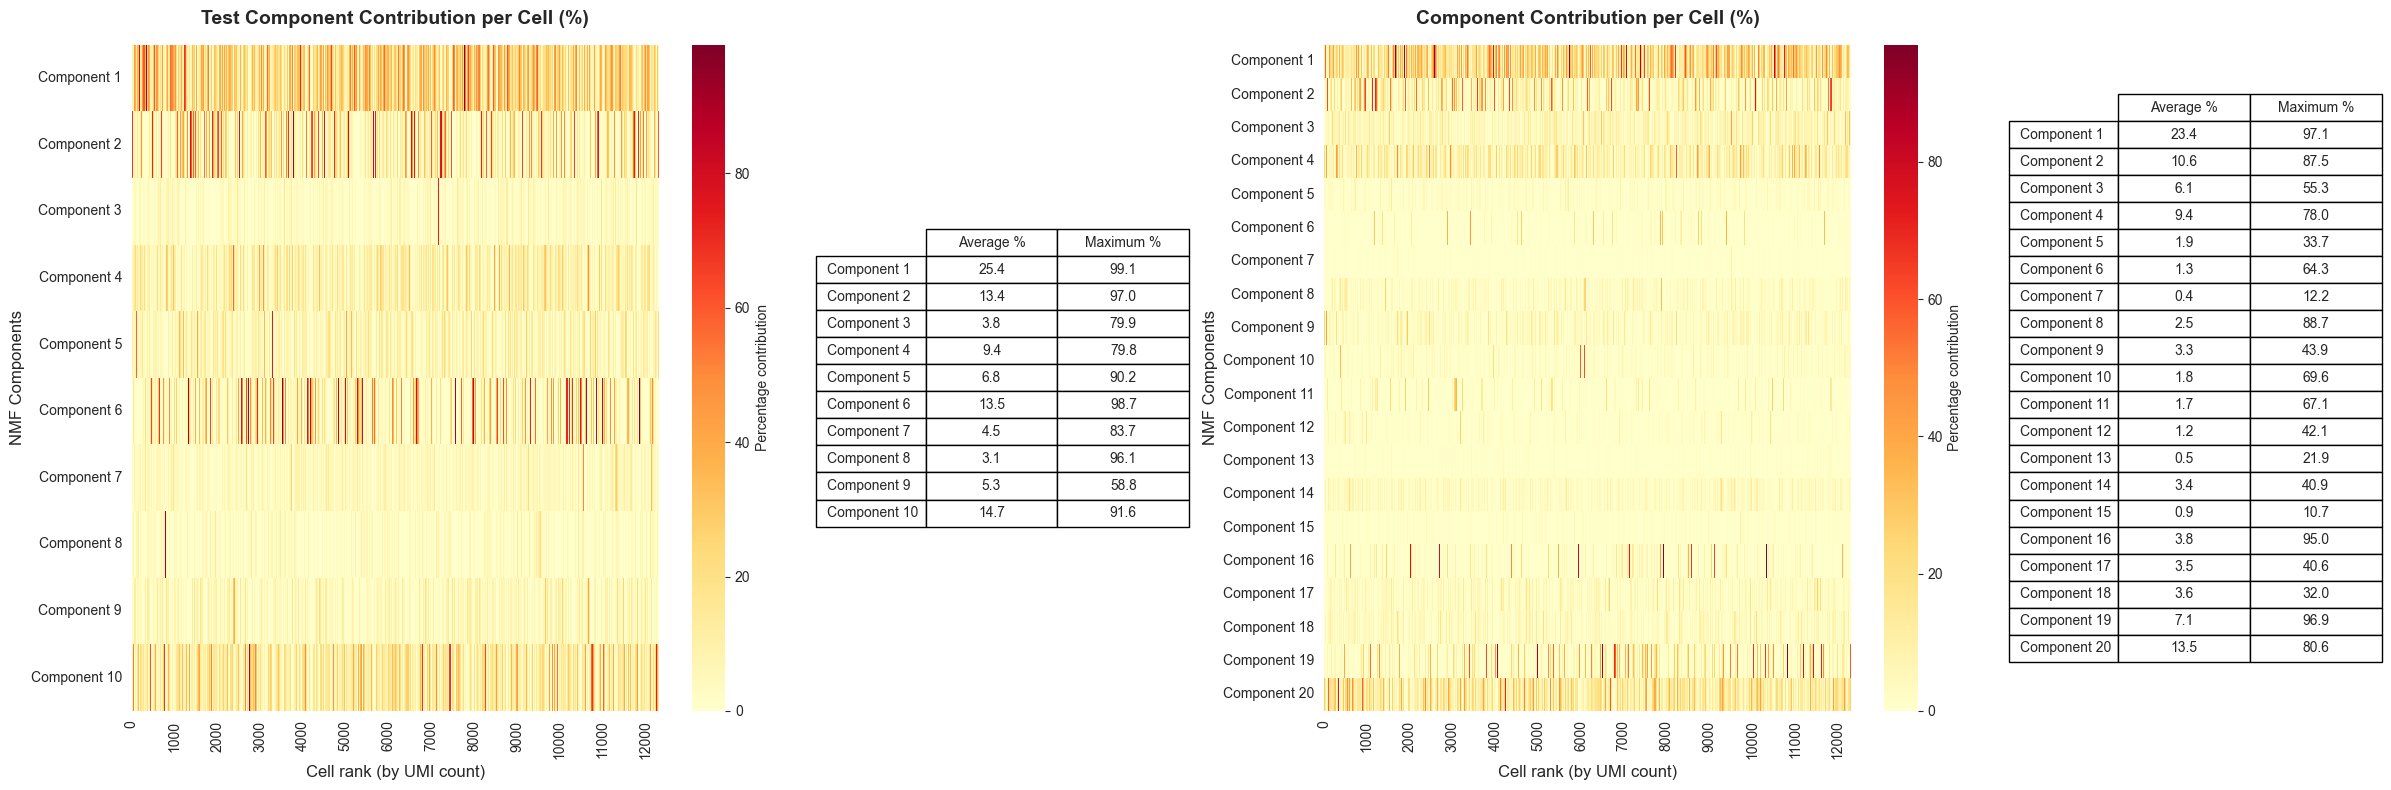

In [ ]:
# Calculate percentage contributions for both matrices
component_percentages_test = W_test_comp / W_test_comp.sum(axis=1)[:, np.newaxis] * 100
component_percentages = W / W.sum(axis=1)[:, np.newaxis] * 100

# Create figure with two subplots, making space for tables
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 4, width_ratios=[3, 1, 3, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax_table1 = fig.add_subplot(gs[1])
ax_table2 = fig.add_subplot(gs[3])

# Get number of cells for x-axis
n_cells = component_percentages_test.shape[0]

# Create heatmap for test components
sns.heatmap(component_percentages_test.T,
            cmap='YlOrRd',
            xticklabels=n_cells//1000,  # Show ticks every 1000 cells
            yticklabels=[f'Component {i+1}' for i in range(test_components)],
            cbar_kws={'label': 'Percentage contribution'},
            ax=ax1)
ax1.set_title('Test Component Contribution per Cell (%)', pad=15, fontsize=14, fontweight='bold')
ax1.set_xlabel('Cell rank (by UMI count)', fontsize=12)
ax1.set_ylabel('NMF Components', fontsize=12)
ax1.set_xticks(np.arange(0, n_cells, 1000))
ax1.set_xticklabels(np.arange(0, n_cells, 1000))

# Create test summary table
test_summary = pd.DataFrame(
    columns=['Average %', 'Maximum %'],
    index=[f'Component {i+1}' for i in range(test_components)]
)
for i in range(test_components):
    test_summary.loc[f'Component {i+1}'] = [
        f"{np.mean(component_percentages_test[:, i]):.1f}",
        f"{np.max(component_percentages_test[:, i]):.1f}"
    ]
ax_table1.axis('off')
table1 = ax_table1.table(cellText=test_summary.values,
                        colLabels=test_summary.columns,
                        rowLabels=test_summary.index,
                        loc='center',
                        cellLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1.2, 1.5)

# Create heatmap for main components
sns.heatmap(component_percentages.T,
            cmap='YlOrRd', 
            xticklabels=n_cells//1000,  # Show ticks every 1000 cells
            yticklabels=[f'Component {i+1}' for i in range(components)],
            cbar_kws={'label': 'Percentage contribution'},
            ax=ax2)
ax2.set_title('Component Contribution per Cell (%)', pad=15, fontsize=14, fontweight='bold')
ax2.set_xlabel('Cell rank (by UMI count)', fontsize=12)
ax2.set_ylabel('NMF Components', fontsize=12)
ax2.set_xticks(np.arange(0, n_cells, 1000))
ax2.set_xticklabels(np.arange(0, n_cells, 1000))

# Create main summary table
main_summary = pd.DataFrame(
    columns=['Average %', 'Maximum %'],
    index=[f'Component {i+1}' for i in range(components)]
)
for i in range(components):
    main_summary.loc[f'Component {i+1}'] = [
        f"{np.mean(component_percentages[:, i]):.1f}",
        f"{np.max(component_percentages[:, i]):.1f}"
    ]
ax_table2.axis('off')
table2 = ax_table2.table(cellText=main_summary.values,
                        colLabels=main_summary.columns,
                        rowLabels=main_summary.index,
                        loc='center',
                        cellLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1.2, 1.5)

plt.tight_layout()
plt.show()


### 6. heatmap color scheme per row

[Text(0, 0, '0'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000'),
 Text(11000, 0, '11000'),
 Text(12000, 0, '12000')]

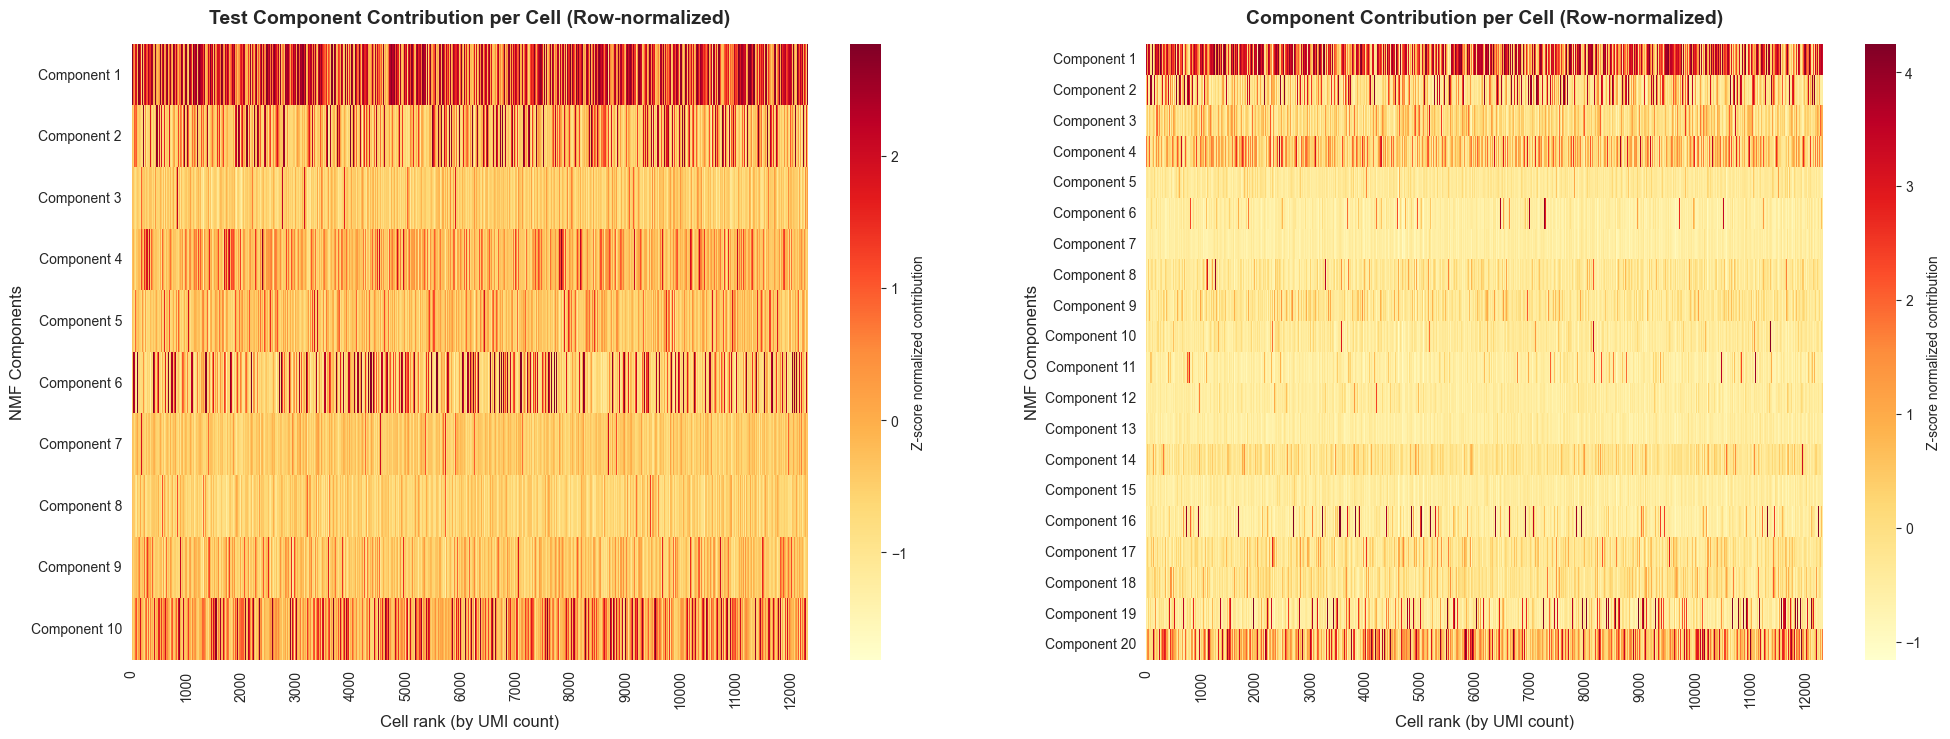

In [ ]:
# Calculate percentage contributions for both matrices
component_percentages_test = W_test_comp / W_test_comp.sum(axis=1)[:, np.newaxis] * 100
component_percentages = W / W.sum(axis=1)[:, np.newaxis] * 100

# Normalize by row (z-score normalization)
component_percentages_test_norm = pd.DataFrame(component_percentages_test).apply(lambda x: (x-x.mean())/x.std(), axis=1).values
component_percentages_norm = pd.DataFrame(component_percentages).apply(lambda x: (x-x.mean())/x.std(), axis=1).values

# Create figure with two subplots, making space for tables
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 3])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Get number of cells for x-axis
n_cells = component_percentages_test_norm.shape[0]

# Create heatmap for test components
sns.heatmap(component_percentages_test_norm.T,
            cmap='YlOrRd',
            xticklabels=n_cells//1000,  # Show ticks every 1000 cells
            yticklabels=[f'Component {i+1}' for i in range(test_components)],
            cbar_kws={'label': 'Z-score normalized contribution'},
            ax=ax1)
ax1.set_title('Test Component Contribution per Cell (Row-normalized)', pad=15, fontsize=14, fontweight='bold')
ax1.set_xlabel('Cell rank (by UMI count)', fontsize=12)
ax1.set_ylabel('NMF Components', fontsize=12)
ax1.set_xticks(np.arange(0, n_cells, 1000))
ax1.set_xticklabels(np.arange(0, n_cells, 1000))


# Create heatmap for main components
sns.heatmap(component_percentages_norm.T,
            cmap='YlOrRd', 
            xticklabels=n_cells//1000,  # Show ticks every 1000 cells
            yticklabels=[f'Component {i+1}' for i in range(components)],
            cbar_kws={'label': 'Z-score normalized contribution'},
            ax=ax2)
ax2.set_title('Component Contribution per Cell (Row-normalized)', pad=15, fontsize=14, fontweight='bold')
ax2.set_xlabel('Cell rank (by UMI count)', fontsize=12)
ax2.set_ylabel('NMF Components', fontsize=12)
ax2.set_xticks(np.arange(0, n_cells, 1000))
ax2.set_xticklabels(np.arange(0, n_cells, 1000))


#### 7. kernel density plot (not possible)

(12315, 10)
<class 'numpy.ndarray'>
step_size/compression factor:  123
sampled:  (101, 10)
sampled.T:  (101, 10)


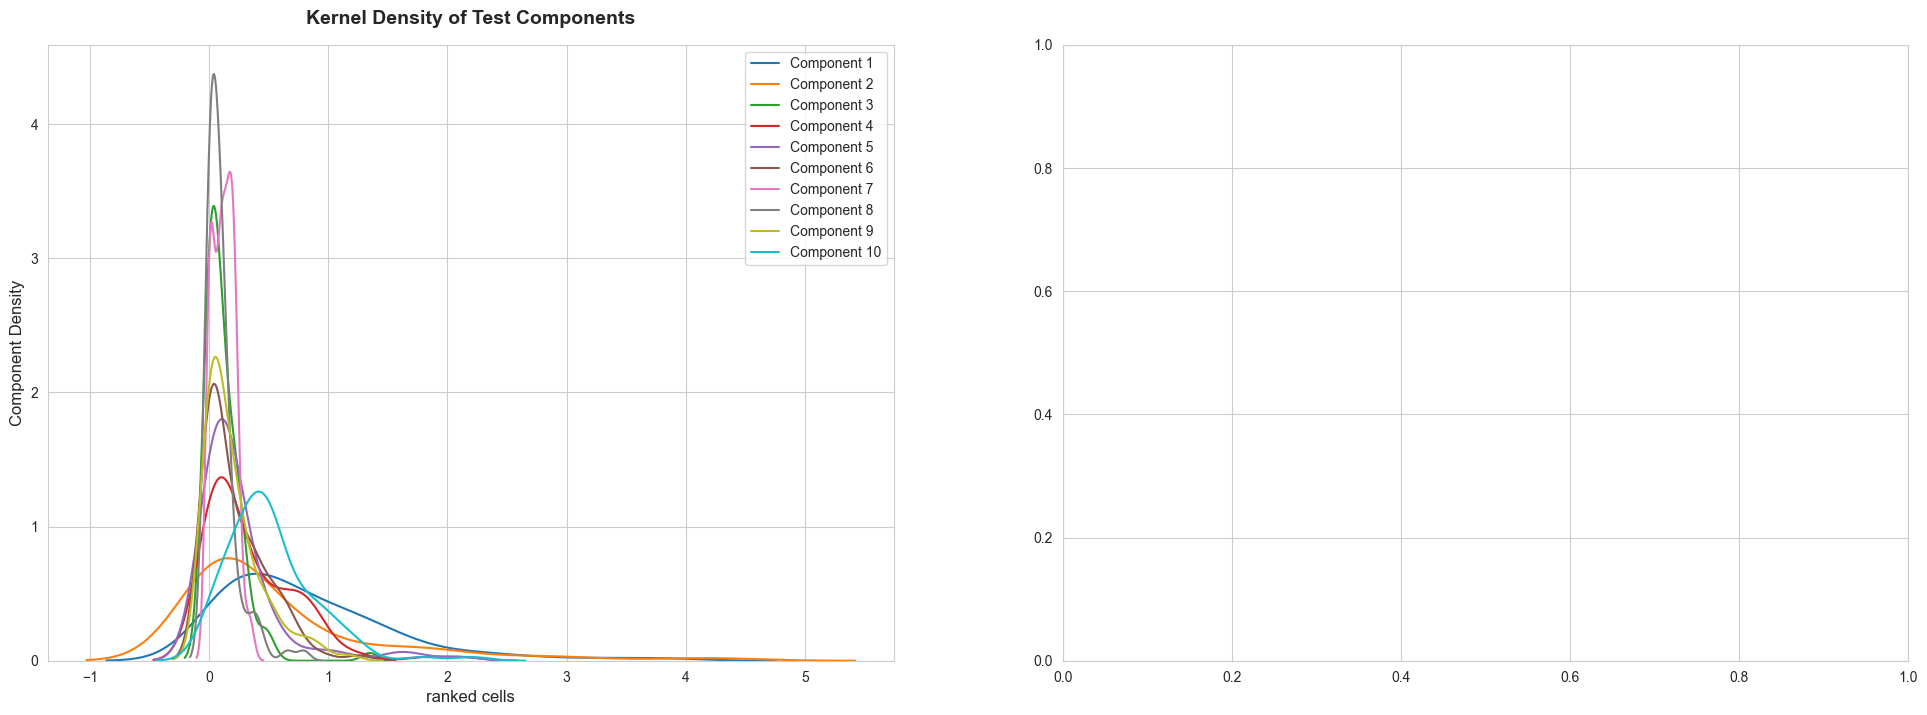

In [ ]:
# Create kernel density plots for components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Plot kernel density for W_test_comp
print(W_test_comp.shape)
print(type(W_test_comp))

# sample data to make plotting manageable
step_size = max(1, W_test_comp.shape[0] // 100)  # Limit to ~1000 points max with //1000, with //100 we will get around 100 cells
print("step_size/compression factor: ", step_size)
W_test_comp_sampled = W_test_comp[::step_size, :]
print("sampled: ", W_test_comp_sampled.shape)

# it is (cells x components) so for each cell we have x-times the components in a numpy array
# we need to transpose so that the kernel density plot is correct
W_test_comp_T = W_test_comp_sampled
print("sampled.T: ", W_test_comp_T.shape)

for i in range(W_test_comp_T.shape[1]):
    #sns.kdeplot(data=W_test_comp_T, ax=ax1, label=f'Component {i+1}') -> error produces 1945 x 7.738.000 pixel big image
    sns.kdeplot(data=W_test_comp_T[:,i], ax=ax1, label=f'Component {i+1}')
ax1.set_title('Kernel Density of Test Components', pad=15, fontsize=14, fontweight='bold')
ax1.set_xlabel('ranked cells', fontsize=12)
ax1.set_ylabel('Component Density', fontsize=12)
ax1.legend()


# Plot kernel density for W
#for i in range(W.shape[1]):
#    sns.kdeplot(data=np.transpose(W), ax=ax2, label=f'Component {i+1}')
#ax2.set_title('Kernel Density of Training Components', pad=15, fontsize=14, fontweight='bold') 
#ax2.set_xlabel('ranked cells', fontsize=12)
#ax2.set_ylabel('Component desnsity', fontsize=12)
#ax2.legend()

#plt.tight_layout()
#plt.show()


# PREPROCESS    - matrix for scanpy "highly_variable_genes"

In [ ]:
# check data
n_obs, n_vars = matrix.shape
print(f"Number of observations (cells): {n_obs}")
print(f"Number of variables (genes): {n_vars}")
print(f"Matrix type: {type(matrix.X)}")

# work on data copy to not change original data
adata = matrix.copy()

# stop warnings by creating unique var names
adata.var_names_make_unique()

# clear inf values to not get the ValueError: cannot specify integer `bins` when input data contains infinity error
# sc.pp.normalize_total(adata, target_sum=1e4)
    # -> creates the non-integer values!!!!
# clear warning: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found
# not working, cant round csr_matrix (sparse) due to memory issues. adata.X = adata.X.round().astype(int)

#sc.pp.log1p(adata)
# -> creates non-integer values!!!!


Number of observations (cells): 12315
Number of variables (genes): 22040
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


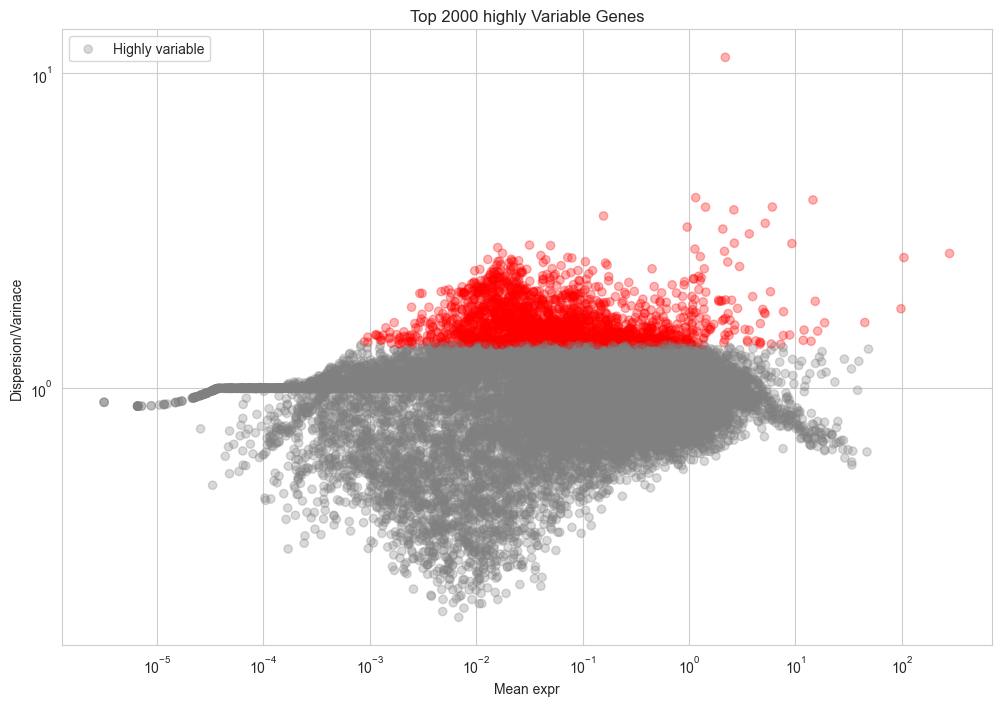

ODF1                  True
DAPL1                 True
ENSSSCG00000053795    True
TWF2                  True
CCDC51                True
                      ... 
ENSSSCG00000061239    True
FKBP7                 True
RSPO2                 True
PTGFRN                True
ACVR1C                True
Name: highly_variable, Length: 150, dtype: bool


In [ ]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=n_variable_genes) #seurat_v3 mimics Seurat’s FindVariableFeatures Function but gets error <<< numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject >>> which occured on numpy versions >1.99
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Create scatter plot of highly variable genes
plt.figure(figsize=(12, 8))
plt.scatter(adata.var['means'], 
           #adata.var['dispersions'], only for non-seurat_v3
           adata.var['variances_norm'],
           c=adata.var.highly_variable.map({True: 'red', False: 'gray'}),
           alpha=0.3)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Mean expr')
plt.ylabel('Dispersion/Varinace')
plt.title(f'Top {n_variable_genes} highly Variable Genes')

plt.legend(['Highly variable', 'Not variable'], loc='upper left')
plt.show()


highly_variable_genes = adata.var['highly_variable']

# sort highly variable genes by rank which is a pandas series
highly_variable_genes_sorted = highly_variable_genes.sort_values(ascending=False)

# get the top 10 highly variable genes
print(highly_variable_genes_sorted.head(150))

# CUT the AnnData-object to the highest 2000 variable genes  

In [ ]:
# Keep only highly variable genes
adata_short = adata[:, adata.var.highly_variable]

print("2000 highly variable genes: ", adata_short.shape)

2000 highly variable genes:  (12315, 2000)


# NMF to shortend anndata

In [ ]:
# First sort the matrix by cell gene counts
cell_gene_counts = np.sum(adata_short, axis=1)  # Sum genes for each cell
sorted_indices = np.argsort(-cell_gene_counts)  # Get indices for descending sort
sorted_ed_matrix = adata_short[sorted_indices]  # Sort the matrix

# Apply NMF on sorted matrix
model = NMF(n_components=components, max_iter=1000)
W = model.fit_transform(sorted_ed_matrix)  # This gives us sorted W matrix
H = model.components_  # H matrix remains the same

print(f"W shape: {W.shape}")
print(f"H shape: {H.shape}")


KeyboardInterrupt: 

# (old) apply NMF to emptydrops.h5.X = ed_matrix

In [ ]:
## First sort the matrix by cell gene counts
#cell_gene_counts = np.sum(ed_matrix, axis=1)  # Sum genes for each cell
#sorted_indices = np.argsort(-cell_gene_counts)  # Get indices for descending sort
#sorted_ed_matrix = ed_matrix[sorted_indices]  # Sort the matrix

# Apply NMF on sorted matrix
#model = NMF(n_components=components, max_iter=500000)
#W = model.fit_transform(sorted_ed_matrix)  # This gives us sorted W matrix
#H = model.components_  # H matrix remains the same

#print(f"H shape: {H.shape}")


In [ ]:
from scipy import ndimage

def plot_components(W, adata, n_components=None, figsize=(12, 8)):
    # 1. UMI counts für jede Zelle berechnen
    umi_counts = np.array(adata.X.sum(axis=1)).flatten()
    print(f"📊 UMI count Bereich: {umi_counts.min():.0f} - {umi_counts.max():.0f}")
    
    # 2. Zellen nach UMI count sortieren (ABSTEIGEND!)
    sorted_indices = np.argsort(umi_counts)[::-1]  # [::-1] = absteigend
    sorted_umi_counts = umi_counts[sorted_indices]
    
    # 3. Zell-Ränge erstellen (1, 2, 3, ...)
    cell_ranks = np.arange(1, len(sorted_indices) + 1)
    
    print(f"Zelle mit höchstem UMI (Rang 1): {sorted_umi_counts[0]:.0f} UMIs")
    print(f"Zelle mit niedrigstem UMI (Rang {len(cell_ranks)}): {sorted_umi_counts[-1]:.0f} UMIs")
    
    plt.figure(figsize=figsize)
    
    # 4. Für jede Komponente: ZELL-Werte gegen Zellrang plotten
    for i in range(n_components):
        # Hole Komponenten-Werte für alle Zellen (NICHT Gene!)
        component_values_per_cell = W[:, i]  # Das sind die ZELL-Loadings!
        
        # Sortiere Komponenten-Werte in derselben Reihenfolge wie UMI-sortierte Zellen
        sorted_component_values = component_values_per_cell[sorted_indices]
        
        plt.plot(cell_ranks, sorted_component_values, 
                linewidth=2, alpha=0.8, label=f'Komponente {i+1}')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Zellrang (absteigend nach UMI count sortiert)', fontsize=12)
    plt.ylabel('NMF Komponenten-Wert (für jede Zelle)', fontsize=12)
    plt.title('NMF Komponenten-Werte vs. Zellrang\\n(X: Zellrang, Y: Komponentenwert pro Zelle)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Info-Box
    plt.text(0.02, 0.98, f'Zellen: {len(cell_ranks):,}\\nKomponenten: {n_components}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return sorted_indices, sorted_umi_counts


sorted_indices, sorted_umi = plot_components(W, adata_short, n_components=components)